<a href="https://colab.research.google.com/github/shadmanshakib09/Rice-Leaf-Disease-Detection-using-Transfer-Learning/blob/main/Rice_Leaf_Disease_Detection_InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/MyDrive

/content/gdrive/MyDrive


In [3]:
%cd CONFERENCE1

/content/gdrive/.shortcut-targets-by-id/14iSH-uYVIsSWIRZ3acFwjZ39HjpSY0kt/CONFERENCE1


In [4]:
import random
import cv2 as cv
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.applications import InceptionV3


In [5]:
IMAGE_SIZE = 224
BATCH_SIZE = 16


CHANNELS = 3


In [6]:
data_dir = '/content/gdrive/MyDrive/CONFERENCE1/train2/'

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4702 files belonging to 3 classes.


In [8]:
class_names = dataset.class_names
print(class_names)
print(f'Total length of dataset: {len(dataset)}')

['BACTERIAL BLIGHT', 'BLAST', 'BROWNSPOT']
Total length of dataset: 294


In [9]:
train_size = 0.8
print(f'Train dataset size: {len(dataset)*train_size}')
train_ds = dataset.take(235)
test_ds = dataset.skip(235)
print(f'Test dataset size: {len(test_ds)}')
val_size = 0.1
# print(len(dataset)*val_size)
val_ds = test_ds.take(30)
print(f'Val dataset size: {len(val_ds)}')
test_ds = test_ds.skip(30)
print(f'Test dataset size: {len(test_ds)}')

Train dataset size: 235.20000000000002
Test dataset size: 59
Val dataset size: 30
Test dataset size: 29


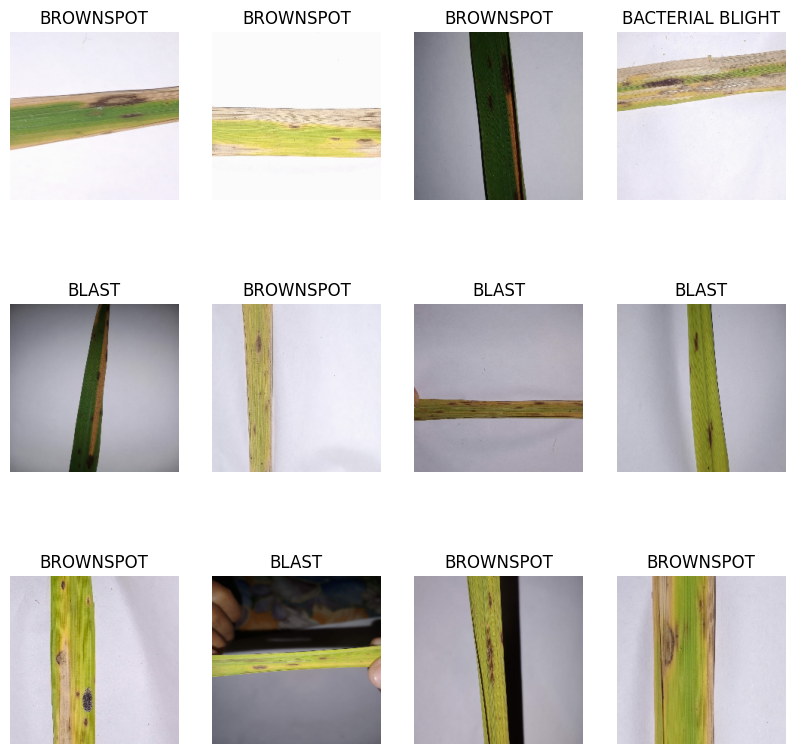

In [10]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
        plt.savefig("input.png")

In [11]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = 30
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    print(len(val_ds))
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

30


In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [16]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [17]:
epochs = 100
num_classes = 3

In [18]:
model1 = Sequential()

pretrained_model = InceptionV3(include_top=False,
                               input_shape=(224,224, 3),
                               pooling='avg', classes=3,
                               weights='imagenet')
print(len(pretrained_model.layers))

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
312


In [20]:
for layer in pretrained_model.layers:
    layer.trainable = False
model1.add(layers.Rescaling(1./255, input_shape=(224,224, 3)))
model1.add(pretrained_model)
model1.add(layers.Flatten())
model1.add(layers.Dense(256, activation='relu'))
model1.add(layers.Dense(128, activation='relu'))
model1.add(layers.Dense(64, activation='relu'))
model1.add(layers.Dense(num_classes, activation='softmax'))
model1.compile(optimizer='adam',
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
model1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 2048)                │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,368,675 (85.33 MB)

 Trainable params: 565,891 (2.16 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

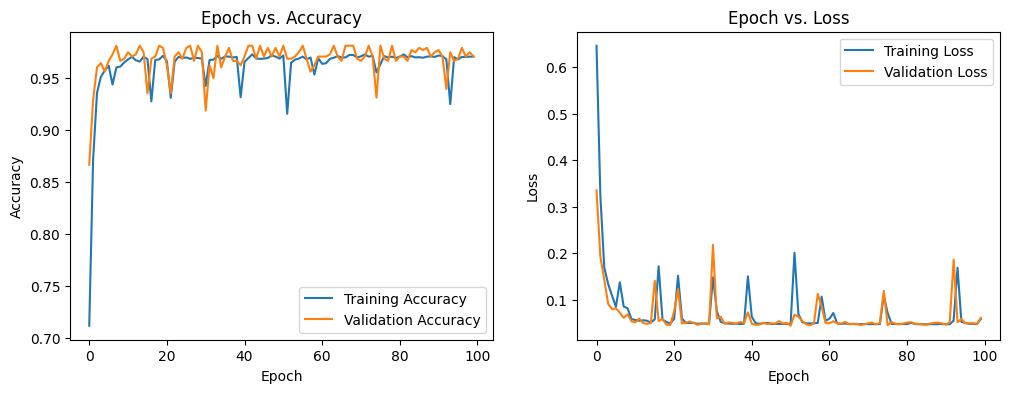

In [ ]:

#Plot epoch vs Accuracy and epoch vs Loss
accuracy = history1.history['accuracy']
val_accuracy = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(range(epochs), accuracy, label='Training Accuracy')
plt.plot(range(epochs), val_accuracy, label='Validation Accuracy')
plt.title('Epoch vs. Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(122)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.title('Epoch vs. Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
history1 = model1.fit(
train_ds,
validation_data=val_ds,
epochs=epochs
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


235/235 [==============================] - 115s 237ms/step - loss: 0.6460 - accuracy: 0.7117 - val_loss: 0.3349 - val_accuracy: 0.8667
Epoch 2/100
235/235 [==============================] - 11s 45ms/step - loss: 0.3219 - accuracy: 0.8721 - val_loss: 0.1916 - val_accuracy: 0.9292
Epoch 3/100
235/235 [==============================] - 11s 46ms/step - loss: 0.1686 - accuracy: 0.9359 - val_loss: 0.1427 - val_accuracy: 0.9604
Epoch 4/100
235/235 [==============================] - 11s 46ms/step - loss: 0.1334 - accuracy: 0.9513 - val_loss: 0.0903 - val_accuracy: 0.9646
Epoch 5/100
235/235 [==============================] - 11s 46ms/step - loss: 0.1085 - accuracy: 0.9574 - val_loss: 0.0795 - val_accuracy: 0.9563
Epoch 6/100
235/235 [==============================] - 11s 45ms/step - loss: 0.0840 - accuracy: 0.9620 - val_loss: 0.0810 - val_accuracy: 0.9667
Epoch 7/100
235/235 [==============================] - 11s 46ms/step - loss: 0.1370 - accuracy: 0.9439 - val_loss: 0.0717 - val_accuracy: 0.

In [ ]:
scores1 = model1.evaluate(test_ds)
print(scores1)
acc = history1.history['accuracy']
print(acc)
val_acc = history1.history['val_accuracy']
print(val_acc)
loss = history1.history['loss']
print(loss)
val_loss = history1.history['val_loss']
print(val_loss)

29/29 [==============================] - 44s 40ms/step - loss: 0.0521 - accuracy: 0.9698
[0.05213628709316254, 0.9698275923728943]
[0.7117021083831787, 0.8720744848251343, 0.9359042644500732, 0.95132976770401, 0.957446813583374, 0.9619680643081665, 0.9438830018043518, 0.9603723287582397, 0.9611701965332031, 0.9651595950126648, 0.9680851101875305, 0.9704787135124207, 0.9672872424125671, 0.9659574627876282, 0.9707446694374084, 0.9683510661125183, 0.9276595711708069, 0.9675531983375549, 0.9680851101875305, 0.9715425372123718, 0.9664893746376038, 0.9311169981956482, 0.9659574627876282, 0.9704787135124207, 0.9694148898124695, 0.9699468016624451, 0.9686170220375061, 0.9696808457374573, 0.9694148898124695, 0.9688829779624939, 0.9425531625747681, 0.9675531983375549, 0.9678191542625427, 0.9715425372123718, 0.9686170220375061, 0.9710106253623962, 0.9707446694374084, 0.9699468016624451, 0.9704787135124207, 0.9316489100456238, 0.9656915068626404, 0.9694148898124695, 0.9728723168373108, 0.968882977

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 48ms/step


ValueError: num must be an integer with 1 <= num <= 9, not 10

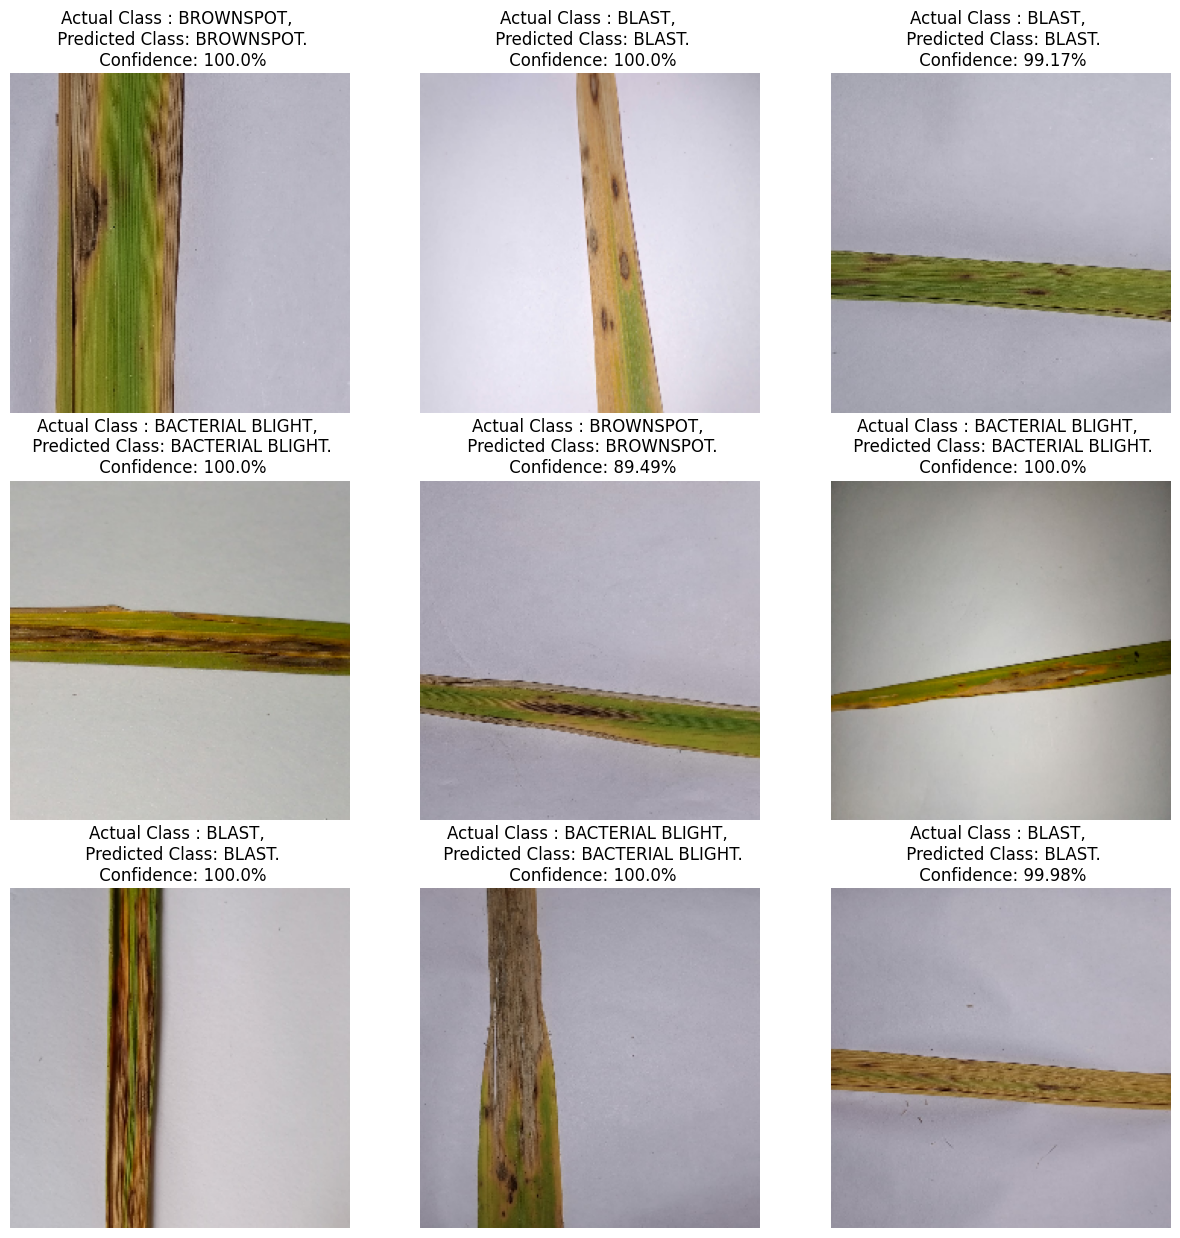

In [ ]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model1, images[i].numpy())

        actual_class = class_names[labels[i]]

        plt.title(f"Actual Class : {actual_class}, \n Predicted Class: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

for image_batch, label_batch in test_ds:
  y_true.append(label_batch)
  preds = model1.predict(image_batch)
  y_pred.append(np.argmax(preds, axis=-1))

correct_labels = tf.concat([item for item in y_true], axis=0)
predicted_labels = tf.concat([item for item in y_pred], axis=0)
conf_matrix = confusion_matrix(correct_labels, predicted_labels)

1/1 [==============================] - 0s 30ms/step


In [ ]:
print(conf_matrix)

[[159   0   5]
 [  1 132   8]
 [  0   0 159]]


In [ ]:
print(classification_report( correct_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       164
           1       1.00      0.94      0.97       141
           2       0.92      1.00      0.96       159

    accuracy                           0.97       464
   macro avg       0.97      0.97      0.97       464
weighted avg       0.97      0.97      0.97       464



In [ ]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc


1/1 [==============================] - 0s 25ms/step


ValueError: num must be an integer with 1 <= num <= 9, not 10

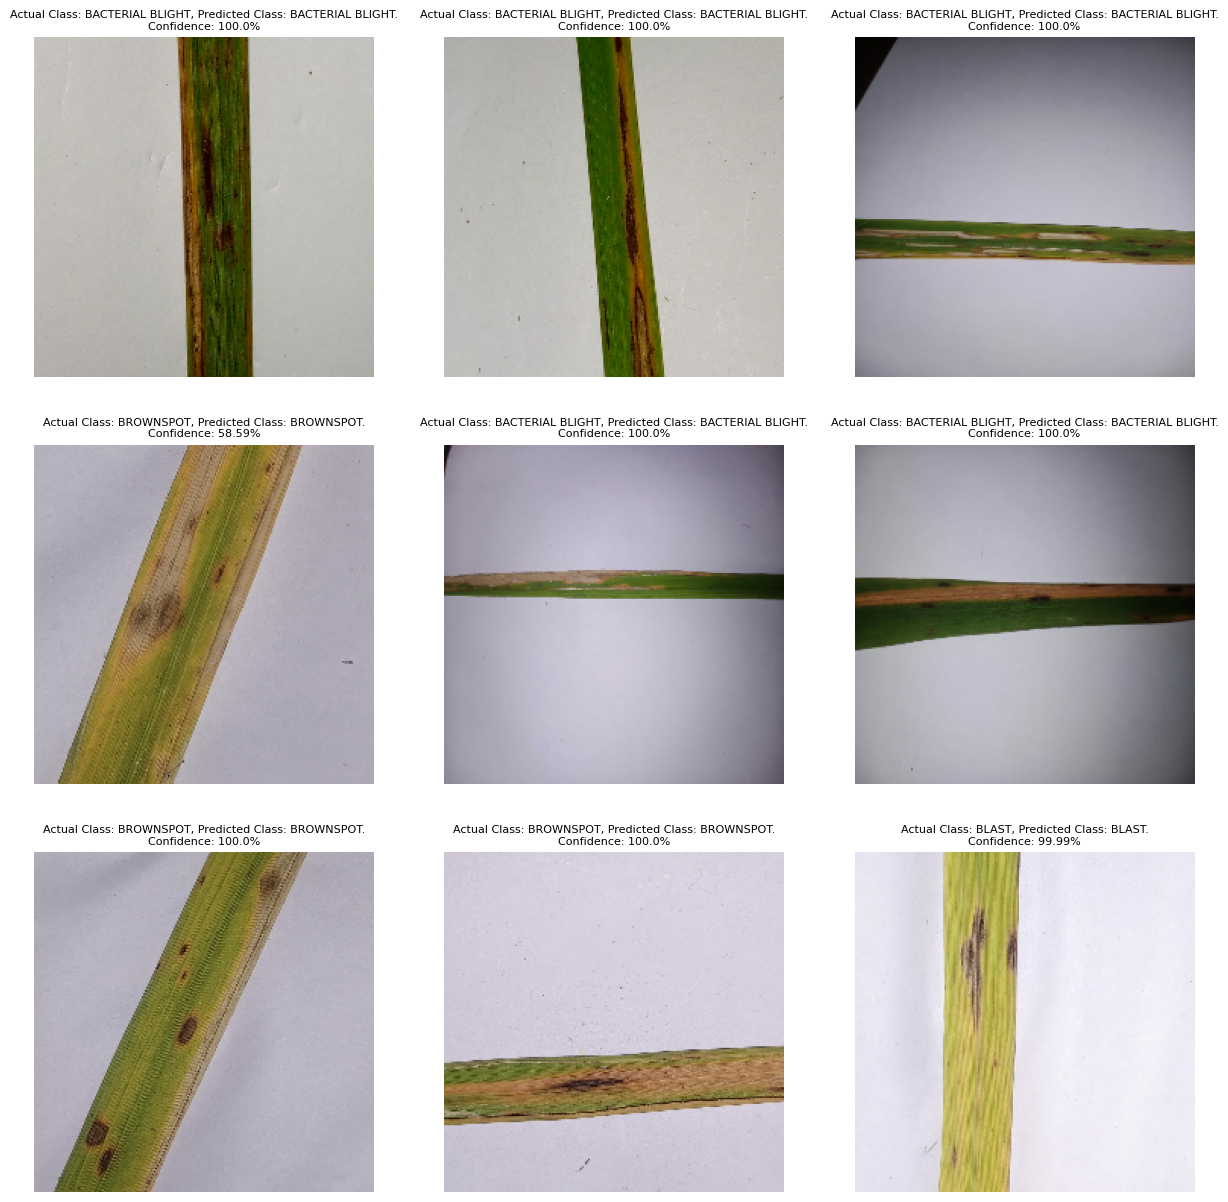

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model1, images[i].numpy())

        actual_class = class_names[labels[i]]

        plt.title(f"Actual Class: {actual_class}, Predicted Class: {predicted_class}.\nConfidence: {confidence}%", fontsize=8)

        plt.axis("off")

plt.show()


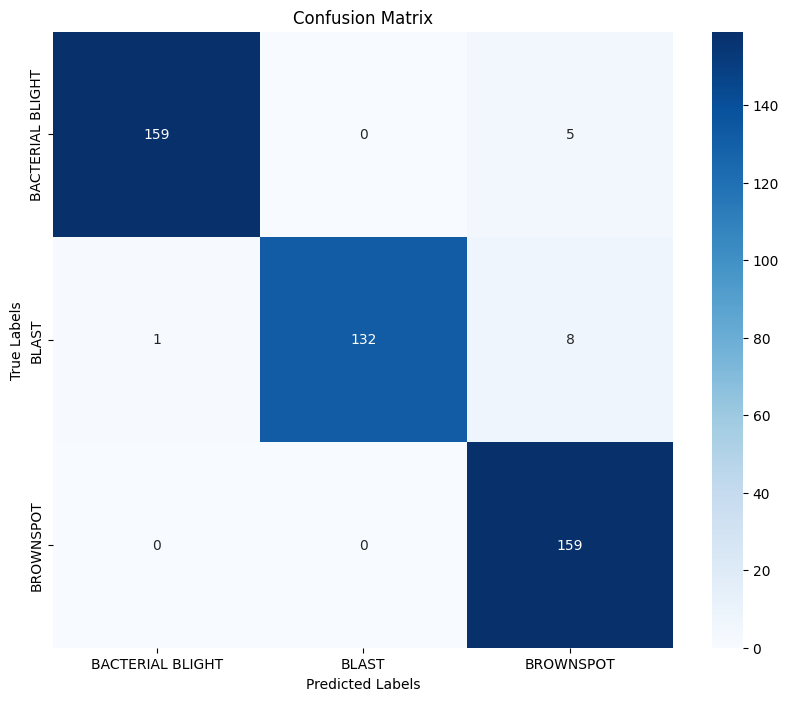

In [ ]:

conf_mat = confusion_matrix(correct_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
print("Mean Absolute Error:" , mean_absolute_error(correct_labels,predicted_labels))

Mean Absolute Error: 0.040948275862068964


In [ ]:
print("Mean Squared Error:" , mean_squared_error(correct_labels,predicted_labels))

Mean Squared Error: 0.0625


29/29 [==============================] - 2s 40ms/step


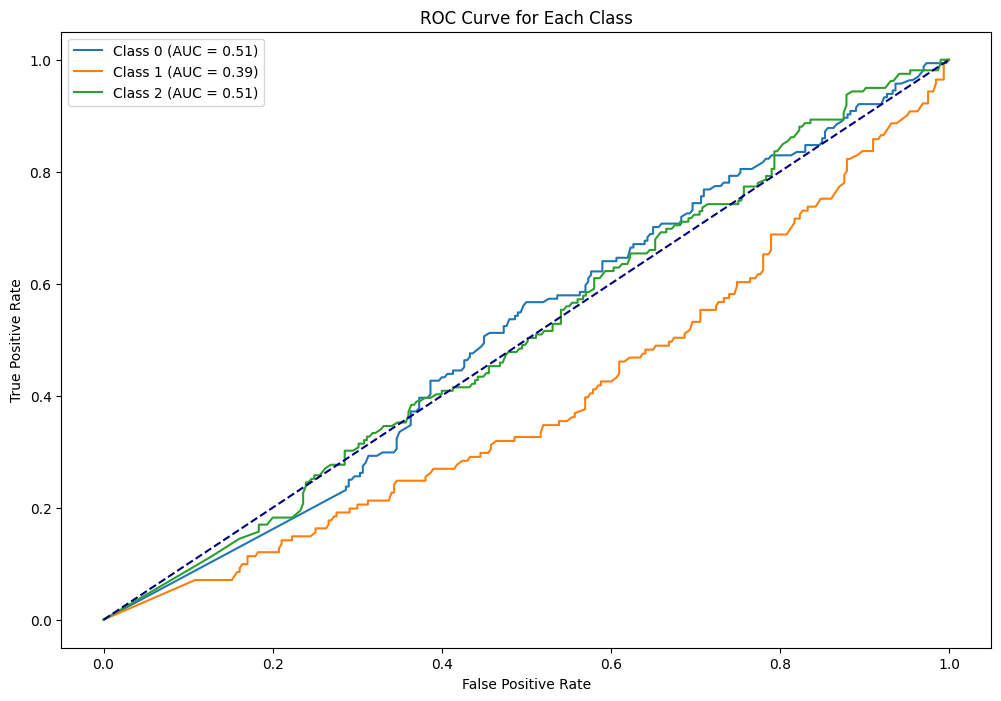

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

# ...

# Get predicted probabilities for each class
y_prob = model1.predict(test_ds)

# Convert true labels to one-hot encoding
y_true_one_hot = tf.keras.utils.to_categorical(correct_labels, num_classes=num_classes)

# Calculate AUC for each class
auc_scores = []
for i in range(num_classes):
    auc_score = roc_auc_score(y_true_one_hot[:, i], y_prob[:, i])
    auc_scores.append(auc_score)

# Plot ROC curve for each class
plt.figure(figsize=(12, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc_scores[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend()
plt.show()


In [ ]:
model1.summary ()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 3)                

In [ ]:
pip install visualkeras


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 5.4 MB/s eta 0:00:00


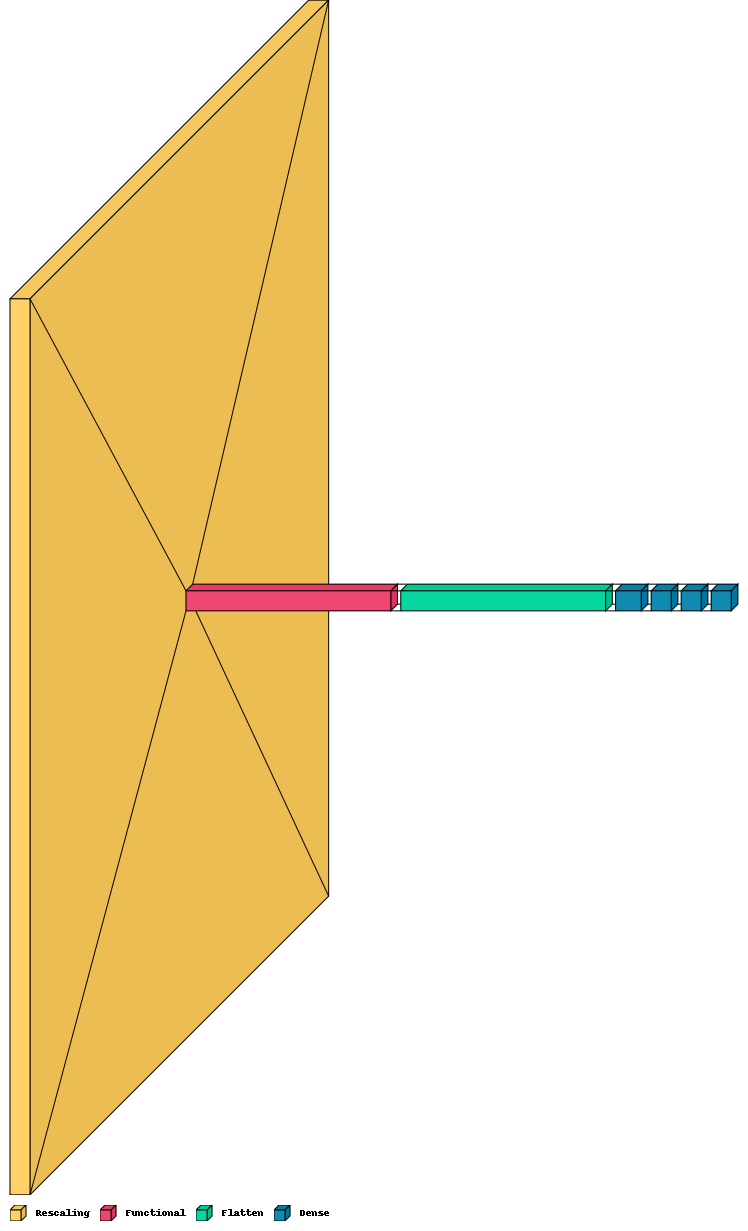

In [ ]:
import visualkeras
visualkeras.layered_view(model1, legend=True) # without custom font
from PIL import ImageFont
visualkeras.layered_view(model1, legend=True)

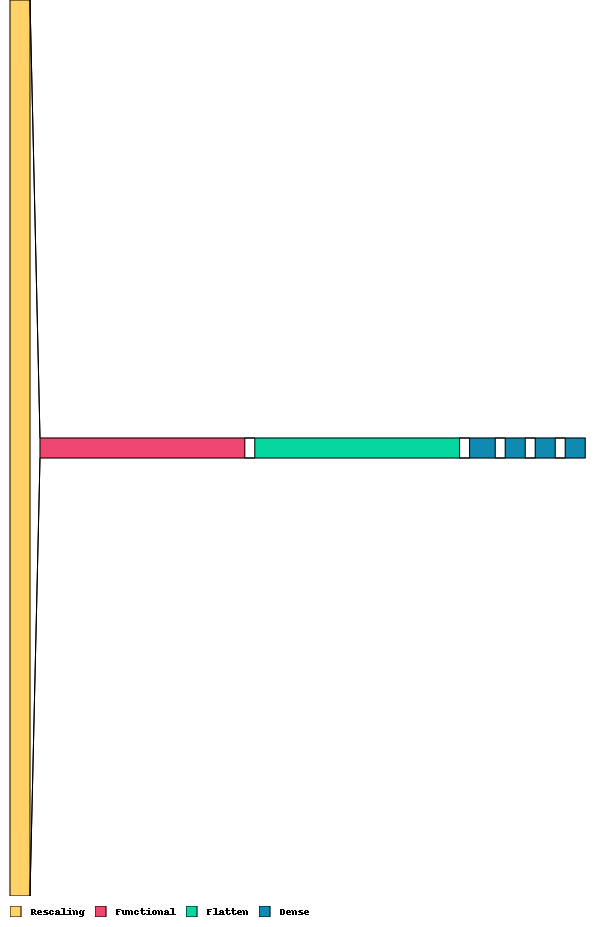

In [ ]:
visualkeras.layered_view(model1, legend=True, draw_volume=False)


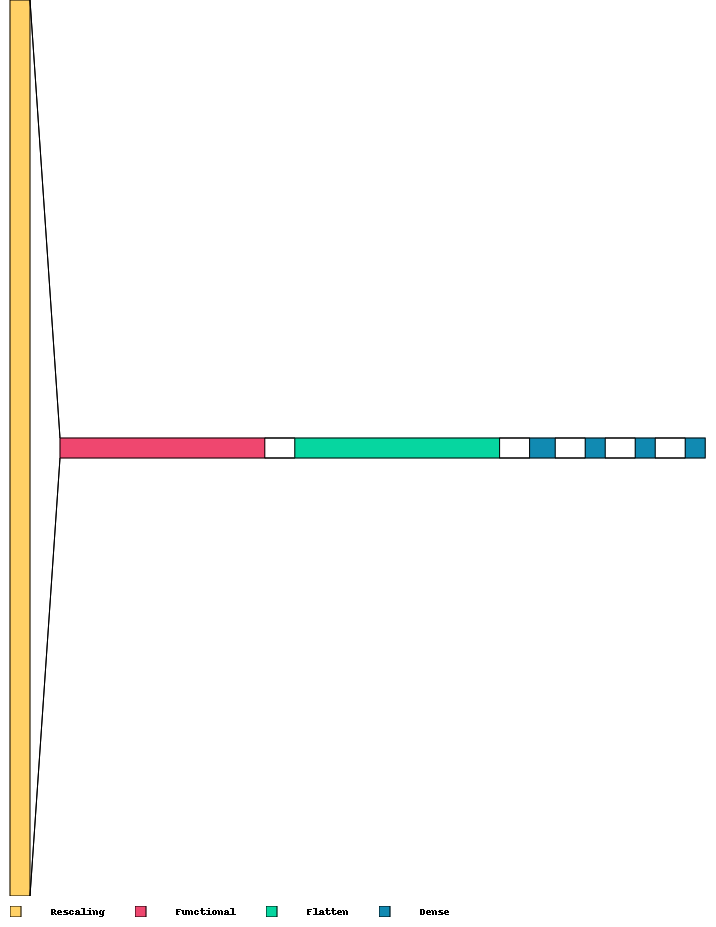

In [ ]:
visualkeras.layered_view(model1, legend=True, draw_volume=False,spacing=30)
